Associated Twitter thread: [Twitter](...)


Another (clearer, shorter) thread on why Student's t-test should NOT be your "go to" test, even if you have massive sample sizes.

I also demonstrate the safer alternative, and demonstrate how it gives similar results to the t-test when the data is "well-behaved"

First, I'll explain this plot ...

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import cauchy, lognorm, norm, pareto, ttest_ind

The $\alpha$ (shape) parameter of Pareto distribution is `b` in `scipy.stats.pareto`.


In [64]:
def students_t_test(control, treatment):
    return ttest_ind(control, treatment).pvalue

def simulate_many(dist, N, reps, test_function, ATE=0.0):
    # The 'test_function' may be 'students_t_test', or the
    # alternative that I promote later in this notebook
    def go():
        control = dist(N)
        treatment = dist(N) + ATE
        return test_function(control, treatment)
    return [go() for _ in range(reps)]
   

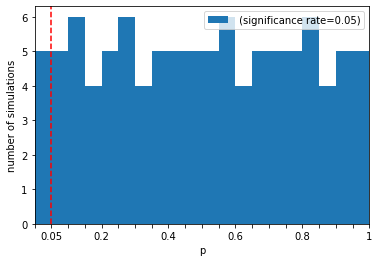

In [47]:
def scatter_with_45degree(ps, label=''):
    ps = np.array(ps)
    significance_rate = (ps<0.05).mean()
    plt.scatter(np.arange(.5, len(ps))/len(ps), sorted(ps), label=f'{label} ({significance_rate})')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.axline((0,0), slope=1)
    plt.legend()
    
def hist_with_significance_rate(ps, label=''):
    ps = np.array(ps)
    significance_rate = (ps<0.05).mean()
    plt.hist(ps, bins=np.arange(0,1.001,.05), label=f'{label} (significance rate={significance_rate})')
    plt.axvline(0.05, ls='dashed', color='red')
    plt.legend()
    plt.xlabel('p')
    plt.ylabel('number of simulations')
    plt.xlim(0,1)
    custom_ticks = np.arange(0,1.00001, .05)
    custom_labels = [
        f'{x:g}'
        # We want labels only at 0.05, and a small number of other interesting locations
        if int(x*100) in [5, 20, 40, 60, 80, 100] else ''
        for x in custom_ticks
    ]
    plt.xticks(custom_ticks, labels=custom_labels)
    
    
hist_with_significance_rate(np.arange(0,1,0.01))

CPU times: user 20.4 s, sys: 47.8 ms, total: 20.5 s
Wall time: 20.4 s


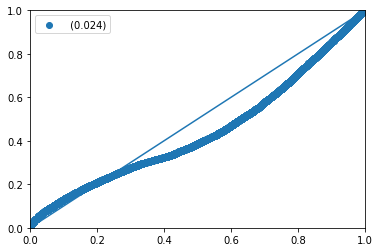

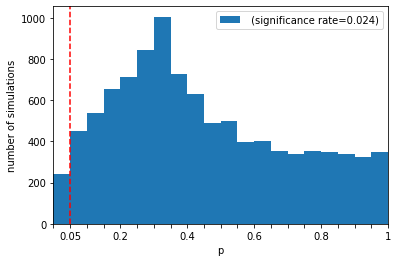

In [48]:
%%time
_ = simulate_many(dist = pareto(b=1.1).rvs, N = 10_000, reps=10000, test_function=students_t_test)

scatter_with_45degree(_)

plt.figure()

hist_with_significance_rate(_)

The null hypothesis is true, therefore we expect about 5% of experiments to be significant.
This is the Type I error rate, and we want it to be close to 5%.
For the t-test, this error rate is too low. This means that even if there is a harmful effect
in your AB test, the t-test is less likely to catch up.

CPU times: user 20.7 s, sys: 44 ms, total: 20.7 s
Wall time: 20.7 s


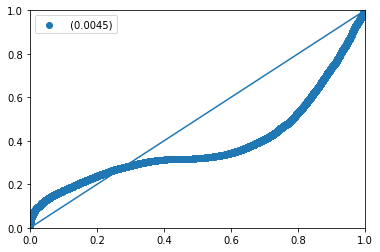

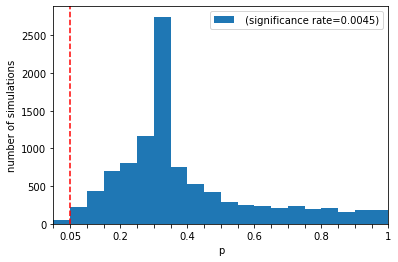

In [50]:
%%time
_ = simulate_many(dist = pareto(b=0.5).rvs, N = 10_000, reps=10000, test_function=students_t_test)

scatter_with_45degree(_)

plt.figure()

hist_with_significance_rate(_)

Starting with code implemented and tested here: https://github.com/aaronmcdaid/aaronmcdaid.github.io/blob/master/notebooks/Students-t-test-considered-harmful-for-AB-testing.ipynb

In [51]:
from collections import namedtuple

class Estimate(namedtuple('Estimate', 'point_estimate variance', module = __name__)):
    # 'point_estimate' is a floating point number.
    # 'variance' may be 'None', or a floating point number. Some methods know how
    # to estimate their own variance, but some methods don't.
    def p_value(self):
        return 2 * norm.cdf(-abs(self.point_estimate / np.sqrt(self.variance)))


# Given a sample and the alpha, compute the trimmed mean and the variance of this estimator
def compute_trimmed_mean_of_a_single_group(xs, alpha):
    assert 0 < alpha < 0.5
    n = len(xs)
    delete_above_this = np.quantile(xs, 1-alpha)
    delete_below_this = np.quantile(xs,   alpha)
    
    filtered = xs[(xs <= delete_above_this) & (xs >= delete_below_this)]
    trimmed_mean = np.mean(filtered)
    
    # Calculate the (asymptotic) variance using section 2.4 of
    # Susan Athey's paper: https://arxiv.org/abs/2109.02603
       
    # mu_bar is the mean where the large and small values are truncated (*not* removed)
    truncated = np.maximum(np.minimum(xs, delete_above_this), delete_below_this)
    mu_bar = np.mean(truncated)
        
    squared_difference = (xs - mu_bar)**2
    squared_difference[(xs > delete_above_this) | (xs < delete_below_this)] = 0
    first_term = np.mean(squared_difference)
    second_term = alpha * (delete_above_this - mu_bar)**2
    third_term = alpha * (delete_below_this - mu_bar)**2
    asymptotic_variance = 1 / (n * (1-2*alpha)**2) * (first_term+second_term+third_term)
    return trimmed_mean, asymptotic_variance

def estimator_adaptive_2sidedtrimmed_means(alphas):
    def go(a, b):
        # Compute a list of two-tuples, pairing the variance with the corresponding alpha
        variances_for_each_possible_alpha = [(
            compute_trimmed_mean_of_a_single_group(a,alpha)[1] + compute_trimmed_mean_of_a_single_group(b,alpha)[1]
            , alpha
        ) for alpha in alphas]
        variance_at_the_optimal_alpha, optimal_alpha = min(variances_for_each_possible_alpha)

        #print(f"optimal_alpha = {optimal_alpha:.3g}")

        estimate_c, estimate_c_var = compute_trimmed_mean_of_a_single_group(a, optimal_alpha)
        estimate_t, estimate_t_var = compute_trimmed_mean_of_a_single_group(b, optimal_alpha)

        return Estimate(point_estimate = estimate_t - estimate_c, variance = estimate_c_var + estimate_t_var)
    return go
        
estimator_adaptive_2sidedtrimmed_means(alphas = np.arange(0.01, 0.49, 0.05))(norm.rvs(size=100), norm.rvs(size=100))


Estimate(point_estimate=-0.13223323980454377, variance=0.016617705751014136)

In [52]:
def adaptive_trimmed_means(control, treatment):
    atm = estimator_adaptive_2sidedtrimmed_means(alphas = np.arange(0.01, 0.49, 0.05))
    return atm(control, treatment).p_value()

CPU times: user 18.1 s, sys: 60.1 ms, total: 18.2 s
Wall time: 18.1 s


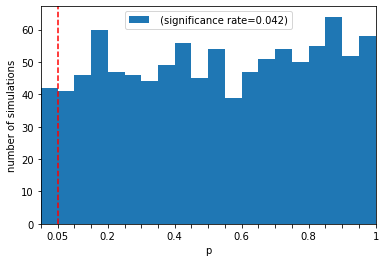

In [57]:
%%time
_ = simulate_many(dist = pareto(b=0.1).rvs, N = 10_000, reps=1000, test_function=adaptive_trimmed_means)
hist_with_significance_rate(_)

In [72]:
!pwd

/home/amcdaid/Fun/aaronmcdaid.github.io/aaronmcdaid.github.io/notebooks


In [71]:
%%time
dist = pareto(b=0.5)
_ = simulate_many(dist = dist.rvs, N = 10_000_000, reps=100, test_function=students_t_test)
hist_with_significance_rate(_)
#plt.figure()
#_ = simulate_many(dist = dist.rvs, N = 10_000, reps=1000, test_function=adaptive_trimmed_means)
#hist_with_significance_rate(_)

KeyboardInterrupt: 

CPU times: user 14.1 s, sys: 40 ms, total: 14.1 s
Wall time: 14 s


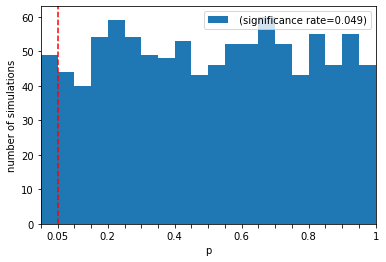

In [68]:
%%time
dist = lognorm(s=1)
_ = simulate_many(dist = dist.rvs, N = 100_000, reps=1000, test_function=students_t_test)
hist_with_significance_rate(_)
#plt.figure()
#_ = simulate_many(dist = dist.rvs, N = 10_000, reps=1000, test_function=adaptive_trimmed_means)
#hist_with_significance_rate(_)